In [21]:
!pip install timm ultralytics
!pip install imbalanced-learn
!pip install torch torchvision opencv-python numpy


In [22]:
import os
import random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report, accuracy_score
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50
from timm import create_model
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.models.segmentation import deeplabv3_resnet50
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report, accuracy_score
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50
from timm import create_model
import torch.nn.functional as F
import cv2
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_f1_score, confusion_matrix, classification_report
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
base_path = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/'
train_path = os.path.join(base_path, 'train')
val_path = os.path.join(base_path, 'valid')
annotation_dir = '/kaggle/working/annotations/'
unet_annotation_dir = '/kaggle/working/unet_annotations/'
os.makedirs(annotation_dir, exist_ok=True)
os.makedirs(unet_annotation_dir, exist_ok=True)


In [24]:
if not os.path.exists(train_path):
    raise FileNotFoundError(f"Training path {train_path} does not exist.")
if not os.path.exists(val_path):
    raise FileNotFoundError(f"Validation path {val_path} does not exist.")

In [25]:
classes = sorted(os.listdir(train_path))
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
train_paths, train_labels = [], []
val_paths, val_labels = [], []

for cls in classes:
    cls_train_path = os.path.join(train_path, cls)
    cls_val_path = os.path.join(val_path, cls)
    for img in os.listdir(cls_train_path):
        if img.endswith('.JPG'):
            train_paths.append(os.path.join(cls_train_path, img))
            train_labels.append(class_to_idx[cls])
    for img in os.listdir(cls_val_path):
        if img.endswith('.JPG'):
            val_paths.append(os.path.join(cls_val_path, img))
            val_labels.append(class_to_idx[cls])

In [26]:
subset_train_paths, subset_train_labels = [], []
subset_val_paths, subset_val_labels = [], []
for cls in classes:
    cls_train_images = [p for p, l in zip(train_paths, train_labels) if l == class_to_idx[cls]]
    cls_val_images = [p for p, l in zip(val_paths, val_labels) if l == class_to_idx[cls]]
    subset_train_paths.extend(random.sample(cls_train_images, min(100, len(cls_train_images))))
    subset_train_labels.extend([class_to_idx[cls]] * min(100, len(cls_train_images)))
    subset_val_paths.extend(random.sample(cls_val_images, min(25, len(cls_val_images))))
    subset_val_labels.extend([class_to_idx[cls]] * min(25, len(cls_val_images)))

print(f"Loaded {len(subset_train_paths)} training and {len(subset_val_paths)} validation images across {len(classes)} classes.")

Loaded 3728 training and 939 validation images across 38 classes.


In [27]:
def suggest_bbox_color(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return [0.5, 0.5, 0.4, 0.4]
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_bound = np.array([0, 40, 30])
    upper_bound = np.array([180, 255, 255])
    mask = cv2.inRange(img_hsv, lower_bound, upper_bound)
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        w, h = min(w, img.shape[1] * 0.8), min(h, img.shape[0] * 0.8)
        x_center = (x + w / 2) / img.shape[1]
        y_center = (y + h / 2) / img.shape[0]
        width = w / img.shape[1]
        height = h / img.shape[0]
        return [x_center, y_center, width, height]
    return [0.5, 0.5, 0.4, 0.4]

In [28]:
def get_unet_model():
    model = deeplabv3_resnet50(pretrained=True)
    model.eval()
    return model.cuda()

def suggest_bbox_unet(image_path, model):
    img = cv2.imread(image_path)
    if img is None:
        return [0.5, 0.5, 0.4, 0.4]
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_tensor = torch.from_numpy(img_rgb / 255.0).permute(2, 0, 1).float().unsqueeze(0).cuda()
    with torch.no_grad():
        output = model(img_tensor)['out']
        mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        w, h = min(w, img.shape[1] * 0.8), min(h, img.shape[0] * 0.8)
        x_center = (x + w / 2) / img.shape[1]
        y_center = (y + h / 2) / img.shape[0]
        width = w / img.shape[1]
        height = h / img.shape[0]
        return [x_center, y_center, width, height]
    return [0.5, 0.5, 0.4, 0.4]

def generate_annotations(image_paths, labels, annotation_dir, use_unet=False):
    if use_unet:
        model = get_unet_model()
        for img_path, label in zip(image_paths, labels):
            bbox = suggest_bbox_unet(img_path, model)
            txt_path = os.path.join(annotation_dir, os.path.basename(img_path).replace('.JPG', '.txt'))
            with open(txt_path, 'w') as f:
                f.write(f"{label} {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}\n")
    else:
        for img_path, label in zip(image_paths, labels):
            bbox = suggest_bbox_color(img_path)
            txt_path = os.path.join(annotation_dir, os.path.basename(img_path).replace('.JPG', '.txt'))
            with open(txt_path, 'w') as f:
                f.write(f"{label} {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}\n")
    print(f"Generated {len(image_paths)} annotations in {annotation_dir}")

In [29]:
generate_annotations(subset_train_paths + subset_val_paths, subset_train_labels + subset_val_labels, annotation_dir, use_unet=False)
generate_annotations(subset_train_paths + subset_val_paths, subset_train_labels + subset_val_labels, unet_annotation_dir, use_unet=True)

Generated 4667 annotations in /kaggle/working/annotations/


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Generated 4667 annotations in /kaggle/working/unet_annotations/


In [30]:
class PlantDataset(Dataset):
    def __init__(self, image_paths, labels, annotation_dir=None, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.annotation_dir = annotation_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        if image is None:
            print(f"Failed to load image: {self.image_paths[idx]}")
            image = np.zeros((224, 224, 3), dtype=np.uint8)
            label = self.labels[idx]
            bbox = [0.5, 0.5, 0.4, 0.4]
        else:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))
            label = self.labels[idx]
            txt_path = os.path.join(self.annotation_dir, os.path.basename(self.image_paths[idx]).replace('.JPG', '.txt')) if self.annotation_dir else None
            if txt_path and os.path.exists(txt_path):
                with open(txt_path, 'r') as f:
                    line = f.readline().strip().split()
                    bbox = [float(x) for x in line[1:5]]
            else:
                bbox = [0.5, 0.5, 0.4, 0.4]
        
        if self.transform:
            image = self.transform(image)
        
        bbox = torch.tensor(bbox, dtype=torch.float32)
        return image, label, bbox

In [31]:


# Compute dataset-specific mean and std
def compute_dataset_stats(image_paths):
    mean, std = np.zeros(3), np.zeros(3)
    n = 0
    for img_path in image_paths[:1000]:  # Sample for efficiency
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0
        mean += img.mean(axis=(0, 1))
        std += img.std(axis=(0, 1))
        n += 1
    mean /= n
    std /= n
    return mean, std

mean, std = compute_dataset_stats(subset_train_paths)
print(f"Dataset Mean: {mean}, Std: {std}")

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

Dataset Mean: [0.4596165  0.48708006 0.41806613], Std: [0.18801931 0.16423744 0.19984509]


In [32]:
val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

In [33]:
train_dataset_color = PlantDataset(subset_train_paths, subset_train_labels, annotation_dir, train_transform)
val_dataset_color = PlantDataset(subset_val_paths, subset_val_labels, annotation_dir, val_transform)
train_dataset_unet = PlantDataset(subset_train_paths, subset_train_labels, unet_annotation_dir, train_transform)
val_dataset_unet = PlantDataset(subset_val_paths, subset_val_labels, unet_annotation_dir, val_transform)
train_loader = DataLoader(train_dataset_unet, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset_unet, batch_size=32, shuffle=False, num_workers=2)

In [34]:


class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out) * x

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(out)
        return self.sigmoid(out) * x

class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super().__init__()
        self.ca = ChannelAttention(in_planes, ratio)
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x):
        x = self.ca(x)
        x = self.sa(x)
        return x

class MambaBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.ssm = nn.Conv1d(dim, dim, kernel_size=3, padding=1, groups=dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(dim * 4, dim)
        )
        self.cbam = CBAM(dim)

    def forward(self, x):
        B, C, H, W = x.shape
        residual = x
        x_flat = x.permute(0, 2, 3, 1).reshape(-1, C)
        x_norm = self.norm(x_flat).reshape(B, H, W, C).permute(0, 3, 1, 2)
        x_ssm = self.ssm(x_norm.flatten(2)).view(B, C, H, W)
        x_mlp = self.mlp(x_norm.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)
        x = residual + x_ssm + x_mlp
        x = self.cbam(x)
        return x

class EfficientNetVMambaYOLO(nn.Module):
    def __init__(self, num_classes=38, embed_dim=96, depth=6):
        super().__init__()
        self.backbone = create_model('efficientnet_b0', pretrained=True, features_only=True)
        self.feature_channels = self.backbone.feature_info[-1]['num_chs']
        self.channel_adjust = nn.Conv2d(self.feature_channels, embed_dim, kernel_size=1)
        self.vmamba_blocks = nn.Sequential(*[MambaBlock(embed_dim) for _ in range(depth)])
        self.grid_size = 7
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.class_head = nn.Linear(embed_dim, num_classes)
        self.bbox_head = nn.Linear(embed_dim, 4)
        self.embed_dim = embed_dim  # Store embed_dim as instance variable

    def forward(self, x):
        x = self.backbone(x)[-1]  # [batch, 1280, 7, 7]
        x = self.channel_adjust(x)  # [batch, 96, 7, 7]
        x = self.vmamba_blocks(x)  # [batch, 96, 7, 7]
        # Classification output using global average pooling
        cls_out = self.pool(x).squeeze(-1).squeeze(-1)  # [batch, 96]
        cls_out = self.class_head(cls_out)  # [batch, num_classes]
        cls_out = torch.softmax(cls_out, dim=-1)
        # Bounding box output for entire grid
        x_bbox = x.permute(0, 2, 3, 1).reshape(-1, self.embed_dim)  # [batch * 7 * 7, 96]
        bbox_out = self.bbox_head(x_bbox).view(-1, self.grid_size, self.grid_size, 4)  # [batch, 7, 7, 4]
        bbox_out = torch.sigmoid(bbox_out)
        return cls_out, bbox_out

In [35]:

class FocalLoss(nn.Module):
    def __init__(self, gamma=1.5, alpha=0.5):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

def compute_giou_loss(pred_boxes, true_boxes):
    # pred_boxes: [batch, grid_size, grid_size, 4]
    # true_boxes: [batch, 4]
    batch_size = pred_boxes.shape[0]
    grid_size = pred_boxes.shape[1]
    pred_boxes = pred_boxes.view(batch_size, -1, 4)  # [batch, grid_size*grid_size, 4]
    true_boxes = true_boxes.unsqueeze(1).expand(-1, grid_size * grid_size, -1)  # [batch, grid_size*grid_size, 4]
    
    x1 = pred_boxes[:, :, 0] - pred_boxes[:, :, 2] / 2
    y1 = pred_boxes[:, :, 1] - pred_boxes[:, :, 3] / 2
    x2 = pred_boxes[:, :, 0] + pred_boxes[:, :, 2] / 2
    y2 = pred_boxes[:, :, 1] + pred_boxes[:, :, 3] / 2
    x1_gt = true_boxes[:, :, 0] - true_boxes[:, :, 2] / 2
    y1_gt = true_boxes[:, :, 1] - true_boxes[:, :, 3] / 2
    x2_gt = true_boxes[:, :, 0] + true_boxes[:, :, 2] / 2
    y2_gt = true_boxes[:, :, 1] + true_boxes[:, :, 3] / 2
    
    x1_inter = torch.max(x1, x1_gt)
    y1_inter = torch.max(y1, y1_gt)
    x2_inter = torch.min(x2, x2_gt)
    y2_inter = torch.min(y2, y2_gt)
    
    inter_area = torch.clamp(x2_inter - x1_inter, min=0) * torch.clamp(y2_inter - y1_inter, min=0)
    pred_area = (x2 - x1) * (y2 - y1)
    gt_area = (x2_gt - x1_gt) * (y2_gt - y1_gt)
    union_area = pred_area + gt_area - inter_area
    
    iou = inter_area / (union_area + 1e-6)
    
    x1_enclose = torch.min(x1, x1_gt)
    y1_enclose = torch.min(y1, y1_gt)
    x2_enclose = torch.max(x2, x2_gt)
    y2_enclose = torch.max(y2, y2_gt)
    enclose_area = (x2_enclose - x1_enclose) * (y2_enclose - y1_enclose)
    
    giou = iou - (enclose_area - union_area) / (enclose_area + 1e-6)
    # Weight by predicted confidence (mean IoU as proxy)
    confidence = iou.detach()
    return (1 - giou).mean()

def compute_loss(outputs, labels, bboxes, num_classes=38):
    criterion_cls = FocalLoss(gamma=1.5, alpha=0.5)
    cls_out, bbox_out = outputs
    cls_loss = criterion_cls(cls_out, labels)
    bbox_loss = compute_giou_loss(bbox_out, bboxes)
    total_loss = cls_loss + 2.0 * bbox_loss
    return total_loss, cls_loss, bbox_loss

In [36]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EfficientNetVMambaYOLO(num_classes=len(classes)).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)  # Start with low LR for warmup
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

num_epochs = 10
warmup_epochs = 5
base_lr = 1e-3

for epoch in range(num_epochs):
    model.train()
    total_loss, total_cls_loss, total_bbox_loss = 0, 0, 0
    # Learning rate warmup
    if epoch < warmup_epochs:
        lr = 1e-5 + (base_lr - 1e-5) * (epoch / warmup_epochs)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    for images, labels, bboxes in train_loader:
        images = images.to(device).float()
        labels = labels.to(device)
        bboxes = bboxes.to(device).float()

        outputs = model(images)
        loss, cls_loss, bbox_loss = compute_loss(outputs, labels, bboxes, len(classes))

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        total_cls_loss += cls_loss.item()
        total_bbox_loss += bbox_loss.item()

    scheduler.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Total Loss: {total_loss:.4f}, Class Loss: {total_cls_loss:.4f}, BBox Loss: {total_bbox_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

Epoch 1/10, Total Loss: 343.9514, Class Loss: 204.4543, BBox Loss: 69.7486, LR: 0.000010
Epoch 2/10, Total Loss: 315.0608, Class Loss: 204.3479, BBox Loss: 55.3564, LR: 0.000207
Epoch 3/10, Total Loss: 305.9675, Class Loss: 204.0141, BBox Loss: 50.9767, LR: 0.000404
Epoch 4/10, Total Loss: 307.2079, Class Loss: 203.8531, BBox Loss: 51.6774, LR: 0.000600
Epoch 5/10, Total Loss: 309.1558, Class Loss: 203.6620, BBox Loss: 52.7469, LR: 0.000795
Epoch 6/10, Total Loss: 309.6015, Class Loss: 203.5327, BBox Loss: 53.0344, LR: 0.000786
Epoch 7/10, Total Loss: 310.4307, Class Loss: 203.4268, BBox Loss: 53.5019, LR: 0.000776
Epoch 8/10, Total Loss: 308.5699, Class Loss: 203.2262, BBox Loss: 52.6719, LR: 0.000764
Epoch 9/10, Total Loss: 309.2891, Class Loss: 203.1994, BBox Loss: 53.0448, LR: 0.000751
Epoch 10/10, Total Loss: 306.4790, Class Loss: 203.0020, BBox Loss: 51.7385, LR: 0.000737


In [37]:


def compute_iou(pred_boxes, true_boxes):
    # pred_boxes: [batch, grid_size, grid_size, 4]
    # true_boxes: [batch, 4]
    batch_size = pred_boxes.shape[0]
    grid_size = pred_boxes.shape[1]
    pred_boxes = pred_boxes.view(batch_size, -1, 4)  # [batch, grid_size*grid_size, 4]
    true_boxes = true_boxes.unsqueeze(1).expand(-1, grid_size * grid_size, -1)  # [batch, grid_size*grid_size, 4]
    
    x1 = pred_boxes[:, :, 0] - pred_boxes[:, :, 2] / 2
    y1 = pred_boxes[:, :, 1] - pred_boxes[:, :, 3] / 2
    x2 = pred_boxes[:, :, 0] + pred_boxes[:, :, 2] / 2
    y2 = pred_boxes[:, :, 1] + pred_boxes[:, :, 3] / 2
    x1_gt = true_boxes[:, :, 0] - true_boxes[:, :, 2] / 2
    y1_gt = true_boxes[:, :, 1] - true_boxes[:, :, 3] / 2
    x2_gt = true_boxes[:, :, 0] + true_boxes[:, :, 2] / 2
    y2_gt = true_boxes[:, :, 1] + true_boxes[:, :, 3] / 2
    
    x1_inter = torch.max(x1, x1_gt)
    y1_inter = torch.max(y1, y1_gt)
    x2_inter = torch.min(x2, x2_gt)
    y2_inter = torch.min(y2, y2_gt)
    
    inter_area = torch.clamp(x2_inter - x1_inter, min=0) * torch.clamp(y2_inter - y1_inter, min=0)
    pred_area = (x2 - x1) * (y2 - y1)
    gt_area = (x2_gt - x1_gt) * (y2_gt - y1_gt)
    union_area = pred_area + gt_area - inter_area
    
    iou = inter_area / (union_area + 1e-6)
    iou = iou.view(batch_size, -1)  # [batch, grid_size*grid_size]
    max_iou, _ = iou.max(dim=1)  # Best IoU per image
    return max_iou.mean().item()

model.eval()
for loader, name in [(val_loader, "U-Net Annotations"), (DataLoader(val_dataset_color, batch_size=32, shuffle=False, num_workers=2), "Color-based Annotations")]:
    preds, trues, pred_bboxes, true_bboxes = [], [], [], []
    with torch.no_grad():
        for images, labels, bboxes in loader:
            images, labels, bboxes = images.to(device), labels.to(device), bboxes.to(device)
            cls_out, bbox_out = model(images)
            
            _, predicted = torch.max(cls_out, 1)
            preds.extend(predicted.cpu().numpy())
            trues.extend(labels.cpu().numpy())
            pred_bboxes.append(bbox_out.cpu().numpy())
            true_bboxes.append(bboxes.cpu().numpy())

    # Convert lists to NumPy arrays
    pred_bboxes = np.concatenate(pred_bboxes, axis=0)
    true_bboxes = np.concatenate(true_bboxes, axis=0)

    acc = accuracy_score(trues, preds) * 100
    precision = precision_score(trues, preds, average='weighted', zero_division=0)
    recall = recall_score(trues, preds, average='weighted', zero_division=0)
    f1 = f1_score(trues, preds, average='weighted', zero_division=0)
    bbox_mse = np.mean((pred_bboxes[:, 3, 3, :] - true_bboxes) ** 2)
    bbox_iou = compute_iou(torch.tensor(pred_bboxes), torch.tensor(true_bboxes))

    print(f"\n--- Evaluation Results ({name}) ---")
    print(f"Validation Accuracy: {acc:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
    print(f"Bounding Box MSE: {bbox_mse:.4f}")
    print(f"Bounding Box IoU: {bbox_iou:.4f}")


--- Evaluation Results (U-Net Annotations) ---
Validation Accuracy: 6.50%
Precision: 0.0062, Recall: 0.0650, F1-score: 0.0112
Bounding Box MSE: 0.0430
Bounding Box IoU: 0.6406

--- Evaluation Results (Color-based Annotations) ---
Validation Accuracy: 6.50%
Precision: 0.0062, Recall: 0.0650, F1-score: 0.0112
Bounding Box MSE: 0.0402
Bounding Box IoU: 0.5441


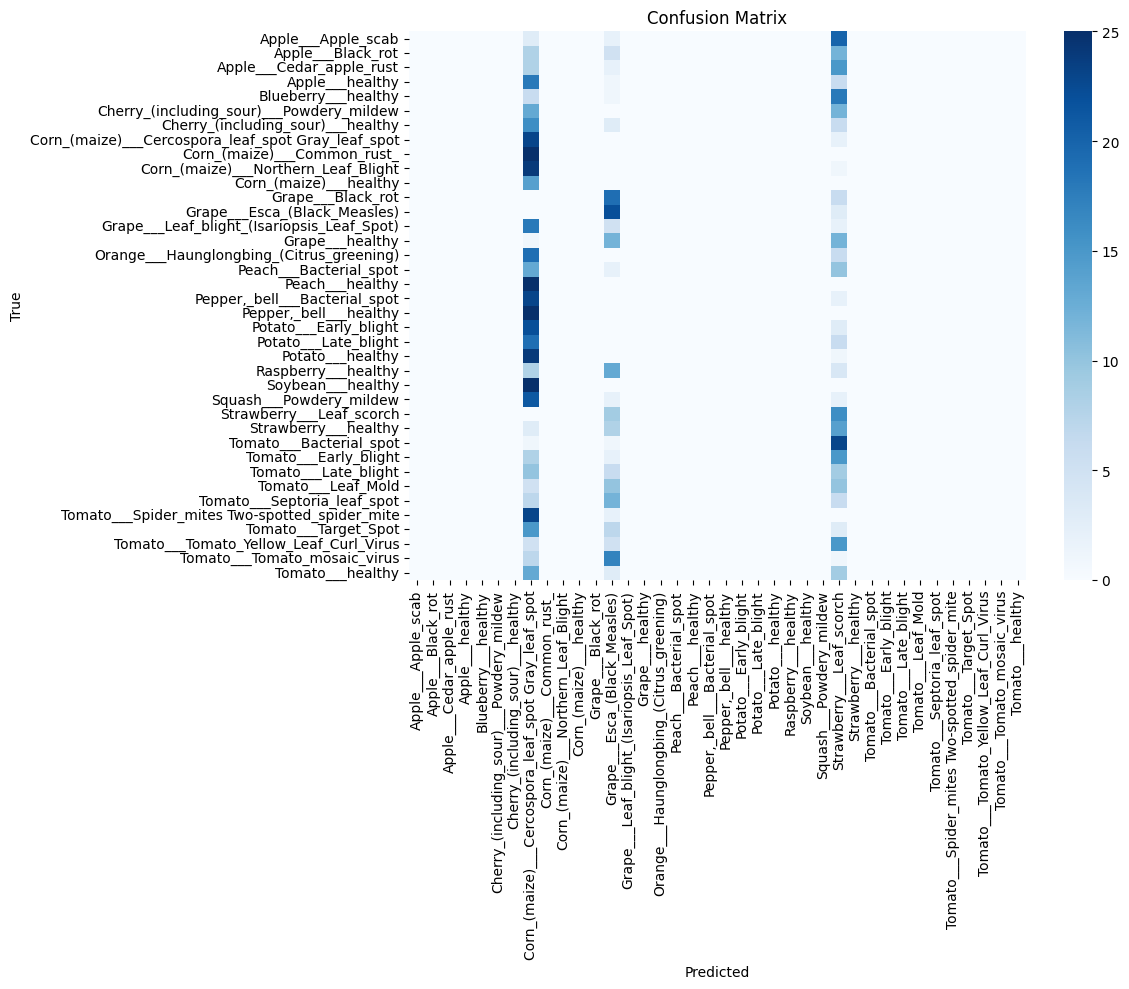


Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.00      0.00      0.00        25
                                 Apple___Black_rot       0.00      0.00      0.00        25
                          Apple___Cedar_apple_rust       0.00      0.00      0.00        25
                                   Apple___healthy       0.00      0.00      0.00        25
                               Blueberry___healthy       0.00      0.00      0.00        25
          Cherry_(including_sour)___Powdery_mildew       0.00      0.00      0.00        25
                 Cherry_(including_sour)___healthy       0.00      0.00      0.00        25
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.05      0.92      0.09        25
                       Corn_(maize)___Common_rust_       0.00      0.00      0.00        25
               Corn_(maize)___Northern_Leaf_Blight     

In [38]:
cm = confusion_matrix(trues, preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(trues, preds, target_names=classes, zero_division=0))

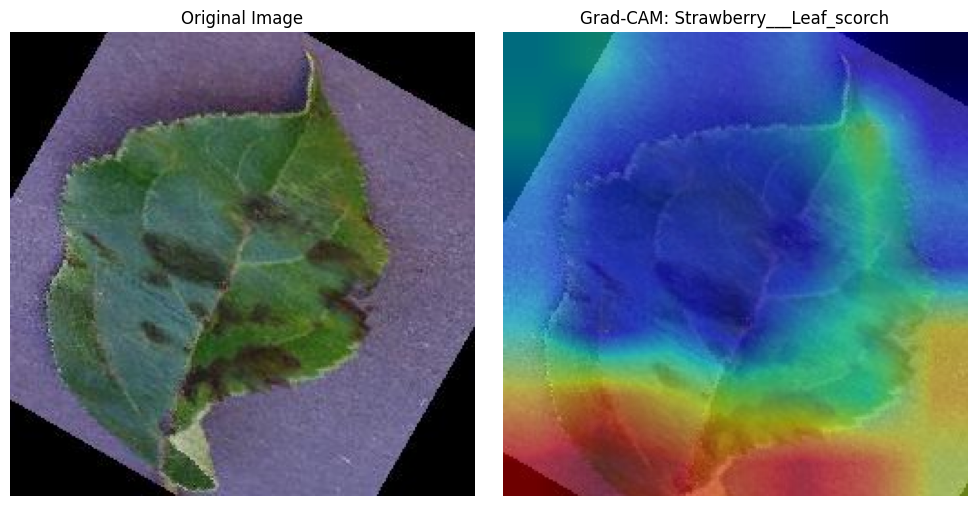

In [39]:


class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.model.eval()
        self.hook_handles = []

    def save_activations(self, module, input, output):
        self.activations = output

    def save_gradient(self, grad):
        self.gradients = grad

    def register_hooks(self):
        target_module = dict(self.model.named_modules())[self.target_layer]
        self.hook_handles.append(target_module.register_forward_hook(self.save_activations))
        self.hook_handles.append(target_module.register_full_backward_hook(
            lambda module, grad_in, grad_out: self.save_gradient(grad_out[0])
        ))

    def generate(self, x, class_idx=None):
        self.activations = None
        self.gradients = None
        self.hook_handles = []
        self.register_hooks()

        # Forward pass
        x = x.requires_grad_()
        cls_out, _ = self.model(x)  # Get cls_out from tuple
        if class_idx is None:
            class_idx = torch.argmax(cls_out[0])

        # Backward pass
        self.model.zero_grad()
        cls_out[0, class_idx].backward()

        # Generate heatmap
        weights = torch.mean(self.gradients, dim=[2, 3], keepdim=True)
        grad_cam = torch.relu(torch.sum(weights * self.activations, dim=1)).squeeze().detach().cpu().numpy()
        grad_cam = cv2.resize(grad_cam, (224, 224))
        grad_cam = (grad_cam - grad_cam.min()) / (grad_cam.max() - grad_cam.min() + 1e-6)

        # Clean up hooks
        for handle in self.hook_handles:
            handle.remove()
        self.hook_handles = []
        return grad_cam

def visualize_grad_cam(model, image_path, transform, class_names):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to load image: {image_path}")
        return
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_tensor = transform(img_rgb).unsqueeze(0).cuda()
    grad_cam = GradCAM(model, 'vmamba_blocks.3')
    heatmap = grad_cam.generate(img_tensor)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_rgb)
    plt.title("Original Image")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(img_rgb)
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.title(f"Grad-CAM: {class_names[torch.argmax(model(img_tensor)[0]).item()]}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_grad_cam(model, subset_train_paths[0], val_transform, classes)

In [40]:
plantvillage_path = '/kaggle/input/plantvillage-dataset/PlantVillage/'
if os.path.exists(plantvillage_path):
    plantvillage_classes = sorted(os.listdir(plantvillage_path))
    plantvillage_paths, plantvillage_labels = [], []
    plantvillage_to_idx = {cls: idx for idx, cls in enumerate(plantvillage_classes)}

    for cls in plantvillage_classes:
        cls_path = os.path.join(plantvillage_path, cls)
        for img in os.listdir(cls_path):
            if img.endswith('.JPG'):
                plantvillage_paths.append(os.path.join(cls_path, img))
                plantvillage_labels.append(plantvillage_to_idx[cls])

    plantvillage_dataset = PlantDataset(plantvillage_paths, plantvillage_labels, annotation_dir=None, transform=val_transform)
    plantvillage_loader = DataLoader(plantvillage_dataset, batch_size=32, shuffle=False, num_workers=2)

    def test_on_plantvillage(model, loader, num_classes=38):
        model.eval()
        preds, trues = [], []
        with torch.no_grad():
            for images, labels, _ in loader:
                images, labels = images.cuda(), labels.cuda()
                cls_out, _ = model(images)
                _, predicted = torch.max(cls_out, 1)
                preds.extend(predicted.cpu().numpy())
                trues.extend(labels.cpu().numpy())
        acc = accuracy_score(trues, preds) * 100
        print(f"PlantVillage Accuracy: {acc:.2f}%")
        return acc

    test_on_plantvillage(model, plantvillage_loader, num_classes=len(classes))
else:
    print("PlantVillage Dataset not found. Skipping cross-dataset testing.")

PlantVillage Dataset not found. Skipping cross-dataset testing.


In [41]:
try:
    from ultralytics import YOLO
    dataset_yaml = """
    train: /kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train
    val: /kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid
    nc: 38
    names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry___Powdery_mildew', 'Cherry___healthy', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']
    """
    with open('/kaggle/working/dataset.yaml', 'w') as f:
        f.write(dataset_yaml)

    model_yolo = YOLO('yolov8n.pt')
    model_yolo.train(data='/kaggle/working/dataset.yaml', epochs=50, imgsz=640)
except ImportError:
    print("Ultralytics YOLO not installed. Skipping YOLOv8 training.")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 86.1MB/s]

Ultralytics 8.3.127 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)


engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/dataset.yaml, degrees=0.0, deterministic=True, device=cuda:0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False, project=None, rect=False, resume=False, retina_masks=False,

100%|██████████| 755k/755k [00:00<00:00, 18.1MB/s]


Overriding model.yaml nc=80 with nc=38

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 75.8MB/s]
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:269: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/torch_utils.py:278: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.8±0.8 ms, read: 2.9±1.5 MB/s, size: 14.6 KB)


train: Scanning /kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Apple_scab... 0 images, 70295 backgrounds, 0 corrupt: 100%|██████████| 70295/70295 [02:27<00:00, 477.49it/s]

WARNING ⚠️ train: No labels found in /kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Apple_scab.cache. See https://docs.ultralytics.com/datasets for dataset formatting guidance.


WARNING ⚠️ train: Cache directory /kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train is not writeable, cache not saved.
WARNING ⚠️ No labels found in /kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Apple_scab.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 1.0±0.5 ms, read: 11.5±16.8 MB/s, size: 16.6 KB)


val: Scanning /kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/Apple___Apple_scab... 0 images, 17572 backgrounds, 0 corrupt: 100%|██████████| 17572/17572 [00:36<00:00, 479.07it/s]

WARNING ⚠️ val: No labels found in /kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/Apple___Apple_scab.cache. See https://docs.ultralytics.com/datasets for dataset formatting guidance.


WARNING ⚠️ val: Cache directory /kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid is not writeable, cache not saved.
WARNING ⚠️ No labels found in /kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/Apple___Apple_scab.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.
Plotting labels to runs/detect/train/labels.jpg... 
WARNING ⚠️ zero-size array to reduction operation maximum which has no identity
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for

  0%|          | 0/4394 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/ultralytics/utils/loss.py:209: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:208.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       1/50      3.21G          0      12.51          0          0        640: 100%|██████████| 4394/4394 [11:20<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R

RuntimeError: torch.cat(): expected a non-empty list of Tensors

In [ ]:
# ------------------- Save Model -------------------
torch.save(model.state_dict(), "/kaggle/working/efficient_vmamba_yolo.pth")
print("Model saved as efficient_vmamba_yolo.pth")